In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import torch
import torch.utils.data as data
from torchvision import transforms
import ast
from torch.nn.utils.rnn import pad_sequence

class MovieDataset(data.Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)[:1000]
        

        self.labels = self.data['averageRating']

    def __len__(self):
        return len(self.data)

    def transfer_to_tensor(self, input):
        a = [torch.tensor(eval(item)) for item in input]
        a = pad_sequence(a)
        a = a.T
        return a

    def __getitem__(self, index):
        item = self.data.iloc[index]
        overviews = self.transfer_to_tensor(self.data['overview'])
        director_ids = self.transfer_to_tensor(self.data['director_ids'])
        genre_ids = self.transfer_to_tensor(self.data['genre_ids'])
        title = self.transfer_to_tensor(self.data['title'])
        
        labels = torch.tensor(item['averageRating'], dtype=torch.long)
        is_adult = torch.tensor(item['isAdult'], dtype=torch.long)  
        start_year = torch.tensor(item['startYear'], dtype=torch.long)  
        runtime_minutes = torch.tensor(item['runtimeMinutes'], dtype=torch.long)
        num_votes = torch.tensor(item['numVotes'], dtype=torch.long)
        title_type = torch.tensor(item['titleType'], dtype=torch.long)
        

        return overviews, director_ids, genre_ids, title, labels, is_adult, start_year, runtime_minutes, num_votes, title_type



In [3]:
import math
import torch
import torch.nn as nn
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
processed_data = pd.read_csv('ready_to_model.csv')
processed_data.head(5)

,Unnamed: 0,Unnamed: 0.1,tconst,titleType,isAdult,startYear,runtimeMinutes,title,averageRating,numVotes,overview,director_ids,genre_ids
0,0,0,0,1,0,1894.0,1.0,"[101, 11425, 26243, 2050, 102]",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
1,1,3,0,1,0,1894.0,1.0,"[101, 11425, 26243, 2050, 1011, 8487, 7677, 21...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
2,2,4,0,1,0,1894.0,1.0,"[101, 1164, 14608, 29732, 29728, 29723, 16177,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
3,3,5,0,1,0,1894.0,1.0,"[101, 1189, 10260, 16856, 29745, 15290, 18947,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
4,4,6,0,1,0,1894.0,1.0,"[101, 1189, 10260, 16856, 29745, 15290, 18947,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"


In [33]:
class BehaviorSequenceTransformer(nn.Module):
    def __init__(self, embedding_dim, num_heads, vocab_size, dropout=0.1):
        super(BehaviorSequenceTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.vocab_size = vocab_size
        # n_director = processed_data.director_ids.max()[0]
        # n_genre = processed_data.genre_ids.max()[0]
        # print(n_director)
        # self.embedding_titleType = nn.Embedding(int(processed_data.titleType.max()) + 1, int(math.sqrt(processed_data.titleType.max())) + 1)
        # self.embedding_startYear = nn.Embedding(int(len(processed_data.startYear.unique())) + 1, int(math.sqrt(len(processed_data.startYear.unique()))) + 1)
        # self.embedding_isAdult = nn.Embedding(2, 2)
        
        # self.embedding_title = nn.Embedding(vocab_size + 1, embedding_dim)
        # self.embedding_overview = nn.Embedding(vocab_size + 1, embedding_dim)
        
        # n_director = processed_data.director_ids.max()[0]
        # n_genre = processed_data.genre_ids.max()[0]
        # self.embedding_director = nn.Embedding(int(n_director) + 1, int(math.sqrt(n_director)) + 1)
        # self.embedding_genre = nn.Embedding(int(n_genre) + 1, int(math.sqrt(n_genre)) + 1)
        self.normal = nn.Sequential(
            nn.Linear(190, 128),
            nn.LeakyReLU(),)
        self.pe = PositionalEncoding(embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)

        self.linear = nn.Sequential(
            nn.Linear(16512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1),
        )

    # def encode_input(self,inputs):
    #     normal_features = inputs[:, :192]
    #     transform_features = inputs[:, 192:704]
    #     start_year = start_year.long()
    #     a = self.embedding_titleType(title_type) , we need longTensor
    #     b = self.embedding_startYear(start_year)
    #     c = self.embedding_isAdult(is_adult)
        
    #     title_feature = self.embedding_title(title)
    #     overview_feature = self.embedding_overview(overview)
    #     f = self.embedding_director(director_ids)
    #     g = self.embedding_genre(genre_ids)        

    #     normal_features = torch.cat((a, b, c, f, g, num_votes, runtime_minutes), 1)

    #     transformer_features = torch.cat((title_feature, overview_feature), 1)
        
        
    #     return transformer_features, normal_features, labels.float()
        
    def forward(self, x): #190 
        normal_features = x[:, 1:191] #batch_size, feature [label=averageRating, isAdult, startYear, runtimeMinutes, numVotes, titleType, director_ids, genre_ids, title, overview]
        transform_features = x[:, 191:704] #191:704 => overview. 
        #print(normal_features.shape)
        normal_features = self.normal(normal_features)
        transformer_features = self.pe(transform_features)
        transformer_output = self.encoder_layer(transformer_features)
        transformer_output = torch.flatten(transformer_output,start_dim=1)
        features = torch.cat((transformer_output, normal_features),dim=1)
        output = self.linear(features)
        return output

In [24]:
processed_data.head(5)

,Unnamed: 0,Unnamed: 0.1,tconst,titleType,isAdult,startYear,runtimeMinutes,title,averageRating,numVotes,overview,director_ids,genre_ids
0,0,0,0,1,0,1894.0,1.0,"[101, 11425, 26243, 2050, 102]",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
1,1,3,0,1,0,1894.0,1.0,"[101, 11425, 26243, 2050, 1011, 8487, 7677, 21...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
2,2,4,0,1,0,1894.0,1.0,"[101, 1164, 14608, 29732, 29728, 29723, 16177,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
3,3,5,0,1,0,1894.0,1.0,"[101, 1189, 10260, 16856, 29745, 15290, 18947,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"
4,4,6,0,1,0,1894.0,1.0,"[101, 1189, 10260, 16856, 29745, 15290, 18947,...",5.7,2052.0,"[101, 1996, 2034, 2450, 2000, 3711, 1999, 2392...",[13780],"[17, 11]"


In [8]:
# merge the data into a big tensor for convenience
import torch
import torch.utils.data as data
from torchvision import transforms
import ast
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
def transfer_to_tensor(input):
        a = torch.tensor(eval(input)) 
        a = pad_sequence(a, maxlen=256)
        a = a.T
        return a
    
dataset = torch.empty((0))
data_list = []
for _, row in tqdm(processed_data.iterrows(), total=processed_data.shape[0]):
    labels = row['averageRating']
    is_adult = row['isAdult']
    start_year = row['startYear']
    runtime_minutes = row['runtimeMinutes']
    num_votes = row['numVotes']
    title_type = row['titleType']

    # Collect all features for this row into a tensor
    row_tensor = torch.tensor([labels, is_adult, start_year, runtime_minutes, num_votes, title_type], dtype=torch.float32)
    data_list.append(row_tensor)

# Stack all row tensors to create a single dataset tensor
dataset = torch.stack(data_list)

print("Dataset shape:", dataset.shape)

100%|██████████| 593791/593791 [00:42<00:00, 14017.62it/s]


Dataset shape: torch.Size([593791, 6])


In [9]:
def transfer_to_tensor(input):
    a = [torch.tensor(eval(item)) for item in input]
    a = pad_sequence(a)
    a = a.T
    return a

overviews = transfer_to_tensor(processed_data['overview'])
print(overviews.shape)
director_ids = transfer_to_tensor(processed_data['director_ids'])
print(director_ids.shape)
genre_ids = transfer_to_tensor(processed_data['genre_ids'])
print(genre_ids.shape)
title = transfer_to_tensor(processed_data['title'])
print(title.shape)

torch.Size([593791, 512])
torch.Size([593791, 59])
torch.Size([593791, 3])
torch.Size([593791, 124])


In [10]:
A = torch.cat((dataset,director_ids, genre_ids, title, overviews), dim = 1)


In [ ]:
A.shape #68 - 704

In [ ]:
593791 * 0.7

100%|██████████| 1302/1302 [00:10<00:00, 128.39it/s]


Epoch 1, Loss: 4.241941928863525


100%|██████████| 1302/1302 [00:09<00:00, 132.04it/s]


Epoch 2, Loss: 3.8559300899505615


100%|██████████| 1302/1302 [00:09<00:00, 130.89it/s]


Epoch 3, Loss: 3.6916897296905518


100%|██████████| 1302/1302 [00:09<00:00, 133.94it/s]


Epoch 4, Loss: 2.94146728515625


100%|██████████| 1302/1302 [00:09<00:00, 131.44it/s]


Epoch 5, Loss: 3.7959563732147217


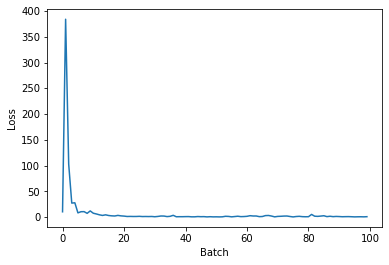

In [34]:
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import matplotlib.pyplot as plt
model = BehaviorSequenceTransformer(embedding_dim=512, num_heads=8, vocab_size= 30522 )
model = model.to(0)
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss
#criterion = nn.RMSELoss()
train = A[: 41653, :]
test = A[41653:,:] 
train = train.to(0)
test = test.to(0)
#A = A.to(0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
batch_size = 32
losses = []
def pad_batch(batch, size, pad_value=0):
    # Padding the batch to the desired size with pad_value
    if len(batch) < size:
        pad_size = size - len(batch)
        padded_part = torch.zeros((pad_size,) + batch.shape[1:], dtype=batch.dtype, device=batch.device).fill_(pad_value)
        batch = torch.cat([batch, padded_part], dim=0)
    return batch
for epoch in range(epochs):
    for i in tqdm(range(0, train.shape[0], batch_size)):
        batch = train[i:i+batch_size]
        if batch.size(0) < batch_size:
            batch = pad_batch(batch, batch_size)
        optimizer.zero_grad()
        output = model(batch[:, 1:])
        loss = criterion(output, batch[:, 0])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')
plt.plot(losses[:])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()



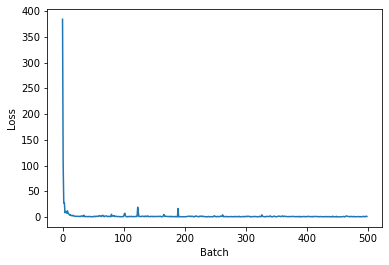

In [37]:
plt.plot(losses[1:500])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()